# Module 4: Simple decision tree classifier

The goal of this demo is to show the concept of class balancing and cross validation.

In [64]:
# sklearn toolkit provides the basic machine learning libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import tree

import pandas as pd
import numpy as np

from IPython.display import Image  
import pydotplus

In [65]:
# get the data from the lecture, a ery simple data frame
datasetDF = pd.read_csv('./demo_2_community_smells_train.csv', sep=";", index_col=0)

In [66]:
datasetDF.head()

,ID,NoD,TAP,LCP,SLC,DC,SDC,BC,CC,TZ,class
0,ApacheDrill,178,10.103,0.5494,42.00,0.02200,0.1522,1.700000e-04,51.0,14,FAULT_PRONE
1,ganttproject,31,9.800,3.2200,485.00,0.18270,0.1670,2.430000e-04,14.0,8,FAULT_PRONE
2,qemu/qemu,1613,8.100,0.0710,251.00,0.00053,0.1570,5.000000e-07,869.0,25,OK
3,nginx/ngin,62,8.100,1.5800,490.00,0.01270,0.2360,3.400000e-05,34.0,12,FAULT_PRONE
4,bitcoin/bitcoin,739,5.300,0.1320,235.85,0.00119,0.1130,2.000000e-08,389.0,29,FAULT_PRONE


In [67]:
# list of columns
datasetDF.columns

Index(['ID', 'NoD', 'TAP', 'LCP', 'SLC', 'DC', 'SDC', 'BC', 'CC', 'TZ',
       'class'],
      dtype='object')

class
FAULT_PRONE    75
OK             21
Name: ID, dtype: int64


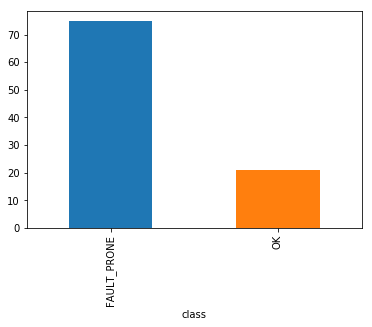

In [68]:
# first we group the items per class
groupedDF = datasetDF.groupby('class').count()

print(groupedDF['ID'])

# and we visualize them in a bar chart
groupedDF['ID'].plot.bar()

Here we can see that the classes are not really balanced, there are more fault prone modules than OK modules. If we leave it like this, then the algorithm will learn that it is better to predict "FAULT_PRONE" simply because these are more statistically valid. 

What we need to do then is to balance these classes -- i.e. make the number of instances from these classes equal. We can do that by upsampling the training data set. 

Since in this workbook I want to show the concept of cross validation we need to divide the set into training and validation set and then we will upsample. 

In [69]:
# create the dataset without the ids
X = datasetDF[['NoD', 'TAP', 'LCP', 'SLC', 'DC', 'SDC', 'BC', 'CC', 'TZ']]
y = datasetDF['class']

In [70]:
# splitting train and test
# in this case, the test data is 30% of the full data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [71]:
print(f'Numer of OKs: {y_train.where(y_train == "OK").count()} and FAULT_PRONE {y_train.where(y_train == "FAULT_PRONE").count()}') 

Numer of OKs: 13 and FAULT_PRONE 54


From the above statistics we can see that the number of OKs is much lower than the number of FAULT_PRONEs. It was like that in the entire data set and it seems to be like that in the training data set. 

So, we need to make the data set balanced. Here, we do it by upsamling the smaller class. We randomly select additional cases from the OKs to make the number of cases similar to the FAULT_PRONE class. 

In [72]:
# if we have unbalanced classes, we need to upsample/downsample
# this script does the upsampling
index_class_0 = np.where( y_train == 'FAULT_PRONE' )[0]
index_class_1 = np.where( y_train == 'OK' )[0]

# Number of observations in each class
n_class0 = len(index_class_0)
n_class1 = len(index_class_1)

# For every observation in class 0, randomly sample from class 1 with replacement
i_class1_upsampled = np.random.choice(index_class_1, size=n_class0, replace=True)

In [73]:
# Join together class 1's upsampled target vector with class 0's target vector
y_train2 = np.concatenate((y_train[y_train.index[i_class1_upsampled]], y_train[y_train.index[index_class_0]]))
X_train2 = np.concatenate((X_train.iloc[i_class1_upsampled], X_train.iloc[index_class_0]))

In [74]:
# Create decision tree classifer object using gini
clf = DecisionTreeClassifier(criterion='gini', random_state=20)

In [75]:
# Train model
model = clf.fit(X_train2, y_train2)

## Visualization of the tree

The big advantage of decision trees, compared to many other algorithms, is that we can visualize it in an intuitive way.

The visualization is intuitive because we can see how the decisions in the tree are made. 

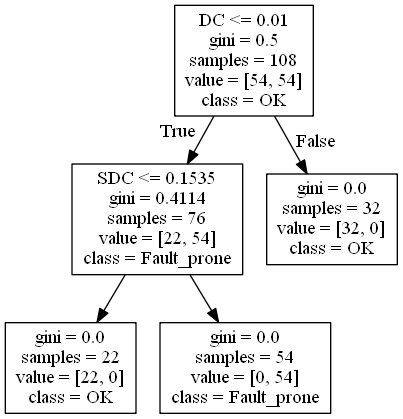

In [76]:
# Create the texttual description of the graph, which can be used for the 
# pydotplus to draw the diagram
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=X.columns,
                                class_names=['OK', 'Fault_prone'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Validation

Before we use the model, let's check how good the model actually is. 

Since we splitted the model into training and test part, we can use the test part to check how well the model has learnt from the data. 

We can use a number of different perfromance metrics here, so let us try some of them.

In [77]:
# first, let's take a look at the F1-measure
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='OK')

print(f'F1: {f1:.3f}')

F1: 1.000


In [78]:
# first, let's take a look at the accuracy-measure
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')

Accuracy: 1.000


### Important note! 

The model seems to be perfect and classifies the instances without any errors. That's true, but it's because of the data set. I used the data set from the previous demo, where we classified all instances based on the manual classes (3+4 instances). 

The data, therefore, was created using the algorithm and therefore the classification is perfect. 

## Using the trained model -- classifying new instances

Now we have trained the model based on the data to train. We can use this model to classify new instances. 

In [79]:
# read the data with the instances to classify
# get the data from the lecture, a ery simple data frame
classifyDF = pd.read_csv('./demo_2_community_smells_predict.csv', sep=",", index_col=False)

In [80]:
classifyDF

,ID,NoD,TAP,LCP,SLC,DC,SDC,BC,CC,TZ
0,new_1,32,22.000,2.5000,165.000,0.013600,0.180000,0.5000,19.00000,8
1,new_2,125,15.000,0.0800,22.500,0.004600,0.129000,0.8990,63.00000,5
2,new_3,115,26.000,0.4800,110.000,0.004800,0.246000,0.5370,76.00000,15
3,new_4,70,7.110,0.0700,11.450,0.006720,0.113000,0.0879,31.00000,13
4,new_5,32,13.000,3.0000,182.110,0.013000,0.163000,0.5270,17.00000,9
5,new_6,71,18.000,0.4800,92.700,0.008600,0.229000,0.7870,45.00000,14
6,new_7,340,8.260,0.1400,165.400,0.002200,0.196000,0.4740,196.00000,13
7,new_8,51,10.000,0.1700,38.040,0.014400,0.188000,0.6250,29.00000,11
8,new_9,41,12.860,3.6400,578.000,0.017000,0.200000,0.7810,24.00000,9
9,new_10,105,12.440,0.6700,275.000,0.007030,0.213000,0.6570,61.00000,15


In [81]:
print(f'Train data columns: {datasetDF.columns}')
print(f'Predict data columns: {classifyDF.columns}')

Train data columns: Index(['ID', 'NoD', 'TAP', 'LCP', 'SLC', 'DC', 'SDC', 'BC', 'CC', 'TZ',
       'class'],
      dtype='object')
Predict data columns: Index(['ID', 'NoD', 'TAP', 'LCP', 'SLC', 'DC', 'SDC', 'BC', 'CC', 'TZ'], dtype='object')


When we look at the two lists above, we see that the predict data set does not have any "class" column in the predict data set

In [82]:
X_to_classify = classifyDF[['NoD', 'TAP', 'LCP', 'SLC', 'DC', 'SDC', 'BC', 'CC', 'TZ']]

In [83]:
# Using the model is very simple, we just ask it to produce the predictions for us
y_to_predict = clf.predict(X_to_classify)

In [84]:
# let's check how the predictions look like
y_predicted = pd.DataFrame(y_to_predict)
y_predicted.columns=['class']
y_predicted.head()

,class
0,FAULT_PRONE
1,FAULT_PRONE
2,OK
3,FAULT_PRONE
4,FAULT_PRONE


In [85]:
classifiedDF = pd.concat([classifyDF['ID'], X_to_classify, y_predicted], axis=1)
classifiedDF.head()

,ID,NoD,TAP,LCP,SLC,DC,SDC,BC,CC,TZ,class
0,new_1,32,22.00,2.50,165.00,0.01360,0.180,0.5000,19.0,8,FAULT_PRONE
1,new_2,125,15.00,0.08,22.50,0.00460,0.129,0.8990,63.0,5,FAULT_PRONE
2,new_3,115,26.00,0.48,110.00,0.00480,0.246,0.5370,76.0,15,OK
3,new_4,70,7.11,0.07,11.45,0.00672,0.113,0.0879,31.0,13,FAULT_PRONE
4,new_5,32,13.00,3.00,182.11,0.01300,0.163,0.5270,17.0,9,FAULT_PRONE


In [86]:
# finally, let's save the data into the .csv file
classifiedDF.to_csv('./community_smells_classified.csv', sep=';')

ModuleNotFoundError: No module named 'pandas.io.formats.csvs'

## Let's just check how many instances were classified to each of the classes

class
FAULT_PRONE    41
OK             15
Name: ID, dtype: int64


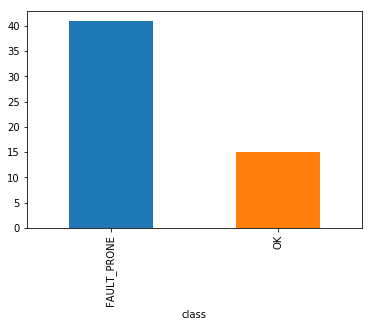

In [87]:
# first we group the items per class
groupedDF = classifiedDF.groupby('class').count()

print(groupedDF['ID'])

# and we visualize them in a bar chart
groupedDF['ID'].plot.bar()

## Additional material

For the visualization please take a look here: https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/

## Important notes

This workbook has a few simplifications, which we need to tackle in a real world scenario. 
1. We did not use any validation of the tree -- this is because the training data is so small that it's difficult to divide it into a smaller chunk. 
2. We did not balanced the classes -- since we have three items in the OK class and four in the FAULT_PRONE class, we do not need to balance the classes. This is again, by design as I did not want to clutter the basic code here. 